# Classify hexagons by their visitors

In [1]:
%load_ext autoreload
%autoreload 2
%cd D:\nine-euro-ticket-de

D:\nine-euro-ticket-de


In [28]:
# Load libs
import pandas as pd
import os
os.environ['USE_PYGEOS'] = '0'
from tqdm import tqdm
import workers
import pickle
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [3]:
# Load hexagons
data_folder = 'dbs/combined_did_data/'
grp, lv = 'all', 'all'
file2 = data_folder + f'h3_grids_dt_{grp}_{lv}.parquet'
df2 = pd.read_parquet(file2)
print(f"Number of unique hexagons for the DT: {df2['h3_id'].nunique()}")

Number of unique hexagons for the DT: 37802


In [4]:
df2.columns

Index(['h3_id', 'date', 'year', 'month', 'weekday', 'precipitation',
       'fuel_price', 'pt_station_num', 'num_visits_wt', 'num_unique_device',
       'd_ha_wt', 'f_share', 'net_rent_100m', 'state', 'district',
       'state_holiday'],
      dtype='object')

In [ ]:
df2plot = df2[['h3_id', 'date', 'year', 'month', 'weekday', 'f_share', 'net_rent_100m', 'district']].copy()
df2plot.rename(columns={'f_share': 'f_share_v', 'net_rent_100m': 'net_rent_v'}, inplace=True)

## 1. Foreigner share

In [5]:
variable2plot = 'f_share_v'
tqdm.pandas()
df_v = df2plot.groupby('date').progress_apply(lambda x: workers.var_hex_date(data=x, variable=variable2plot)).\
    reset_index(drop=True).assign(policy='dt')
df_v.to_parquet(os.path.join(f"results/hex_time_series/{grp}_{lv}_{variable2plot}.parquet"), index=False)

100%|██████████| 175/175 [00:07<00:00, 22.87it/s]


<img src="https://raw.githubusercontent.com/MobiSegInsights/nine-euro-ticket-de/main/figures/manuscript/hex_time_series_all_all_f_share_v.png" alt="Drawing" style="width: 800px;" />

In [6]:
# Get district quantile groups
df2f = df2plot.groupby(['h3_id', 'district'])['f_share_v'].mean().reset_index()
df2f_dvs = df2f.groupby('district').apply(lambda x: pd.Series(dict(dvs=[x['f_share_v'].quantile(i) for i in [0.25, 0.5, 0.75]]))).reset_index()
# Convert to dictionary {col1: col2}
result_dict = df2f_dvs.set_index('district')['dvs'].to_dict()

In [7]:
# District level grouping
def grouping_by_district(data):
    data_r = data[['f_share_v', 'h3_id', 'date']].copy()
    dvs = result_dict[data.name]
    data_r.loc[:, 'f_grp'] = pd.cut(data_r['f_share_v'], [-0.01] + dvs + [10000], labels=['q1', 'q2', 'q3', 'q4'])
    return data_r

tqdm.pandas()
df2plot_grp = df2plot.groupby('district').progress_apply(grouping_by_district).reset_index().sort_values(by=['h3_id'])
df2plot_grp.head()

100%|██████████| 378/378 [00:01<00:00, 202.77it/s]


,district,level_1,f_share_v,h3_id,date,f_grp
1283488,Görlitz,163,12.288812,881e265325fffff,2023-04-24,q4
1283798,Görlitz,473,11.861615,881e265325fffff,2023-05-19,q4
1283797,Görlitz,472,12.232948,881e265325fffff,2023-04-25,q4
1283796,Görlitz,471,12.628129,881e265325fffff,2023-04-01,q4
1283795,Görlitz,470,13.225372,881e265325fffff,2023-03-28,q4


In [8]:
# Calculate the share of occurrences for each f_gpp group
df_grouped = df2plot_grp.groupby(['h3_id', 'f_grp']).size().unstack(fill_value=0)

# Normalize to get shares
df_shares = df_grouped.div(df_grouped.sum(axis=1), axis=0)

# Reset index to make h3_id a column
df_shares = df_shares.reset_index()

# Rename columns to include q1, q2, q3, q4
df_shares = df_shares.reindex(columns=['h3_id', 'q1', 'q2', 'q3', 'q4'], fill_value=0)
df_shares.head()

f_grp,h3_id,q1,q2,q3,q4
0,881e265325fffff,0.022857,0.051429,0.194286,0.731429
1,881e26532dfffff,0.084337,0.204819,0.433735,0.277108
2,881e265367fffff,0.111111,0.055556,0.166667,0.666667
3,881e26ca39fffff,0.500000,0.125000,0.107143,0.267857
4,881e26cb65fffff,0.718750,0.125000,0.083333,0.072917


In [9]:
threshold_impact = list()
for threshold in tqdm(range(1, 10), 'Threshold testing'):
    threshold /= 10
    def grouping(row):
        q_list = [row['q1'], row['q2'], row['q3'], row['q4']]
        if max(q_list) >= threshold:
            return f'q{q_list.index(max(q_list)) + 1}'
        else:
            return 'q0'
    df_shares.loc[:, 'f_grp'] = df_shares.apply(lambda row: grouping(row), axis=1)
    length_q0 = len(df_shares[df_shares['f_grp'] == 'q0'])
    features = df_shares[['q1', 'q2', 'q3', 'q4']]
    pred_labels = df_shares['f_grp']
    silhouette_avg = silhouette_score(features, pred_labels)
    ch_score = calinski_harabasz_score(features, pred_labels)
    db_score = davies_bouldin_score(features, pred_labels)
    threshold_impact.append((threshold, length_q0/len(df_shares), silhouette_avg, ch_score, db_score))
df_thr = pd.DataFrame(threshold_impact, columns=['threshold', 'share_q0', 'silhouette_avg', 'ch_score', 'db_score'])

Threshold testing: 100%|██████████| 9/9 [02:16<00:00, 15.14s/it]


<Axes: xlabel='threshold'>

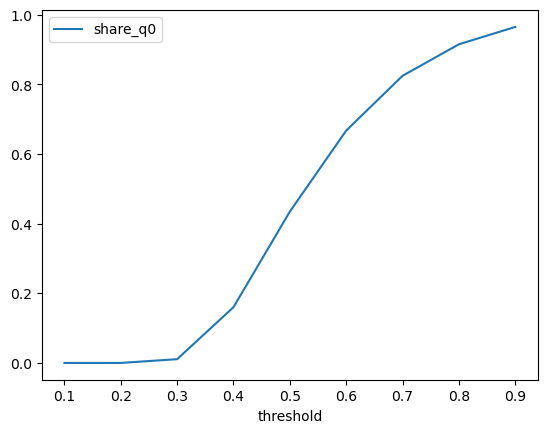

In [10]:
df_thr.plot(x='threshold', y='share_q0')

<Axes: xlabel='threshold'>

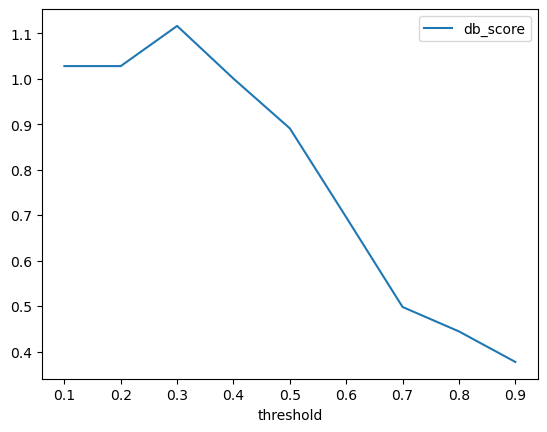

In [13]:
df_thr.plot(x='threshold', y='db_score')

### Select threshold = 0.5

In [12]:
threshold = 0.5
def grouping(row):
        q_list = [row['q1'], row['q2'], row['q3'], row['q4']]
        if max(q_list) >= threshold:
            return f'q{q_list.index(max(q_list)) + 1}'
        else:
            return 'q0'
df_shares.loc[:, 'f_grp'] = df_shares.apply(lambda row: grouping(row), axis=1)
length_q0 = len(df_shares[df_shares['f_grp'] == 'q0'])
features = df_shares[['q1', 'q2', 'q3', 'q4']]
pred_labels = df_shares['f_grp']
silhouette_avg = silhouette_score(features, pred_labels)
ch_score = calinski_harabasz_score(features, pred_labels)
db_score = davies_bouldin_score(features, pred_labels)
print((threshold, length_q0/len(df_shares), silhouette_avg, ch_score, db_score))    # Peak ch_score

(0.5, 0.43473890270356064, 0.3636867650036115, 19893.031416859267, 0.8907638487384599)


In [14]:
f_grp_dict = df_shares.set_index('h3_id')['f_grp'].to_dict()

## 2. Net rent

In [15]:
variable2plot = 'net_rent_v'
tqdm.pandas()
df_v = df2plot.groupby('date').progress_apply(lambda x: workers.var_hex_date(data=x, variable=variable2plot)).\
    reset_index(drop=True).assign(policy='dt')
df_v.to_parquet(os.path.join(f"results/hex_time_series/{grp}_{lv}_{variable2plot}.parquet"), index=False)

100%|██████████| 175/175 [00:07<00:00, 22.81it/s]


<img src="https://raw.githubusercontent.com/MobiSegInsights/nine-euro-ticket-de/main/figures/manuscript/hex_time_series_all_all_net_rent_v.png" alt="Drawing" style="width: 800px;" />

In [16]:
# Get district quantile groups
df2f = df2plot.groupby(['h3_id', 'district'])[variable2plot].mean().reset_index()
df2f_dvs = df2f.groupby('district').apply(lambda x: pd.Series(dict(dvs=[x[variable2plot].quantile(i) for i in [0.25, 0.5, 0.75]]))).reset_index()
# Convert to dictionary {col1: col2}
result_dict = df2f_dvs.set_index('district')['dvs'].to_dict()

In [20]:
# District level grouping
def grouping_by_district_r(data):
    data_r = data[[variable2plot, 'h3_id', 'date']].copy()
    dvs = result_dict[data.name]
    data_r.loc[:, 'r_grp'] = pd.cut(data_r[variable2plot], [-0.01] + dvs + [10000], labels=['q1', 'q2', 'q3', 'q4'])
    return data_r

tqdm.pandas()
df2plot_grp = df2plot.groupby('district').progress_apply(grouping_by_district_r).reset_index().sort_values(by=['h3_id'])
df2plot_grp.head()

100%|██████████| 378/378 [00:01<00:00, 214.86it/s]


,district,level_1,net_rent_v,h3_id,date,r_grp
1283488,Görlitz,163,5.266400,881e265325fffff,2023-04-24,q2
1283798,Görlitz,473,4.850671,881e265325fffff,2023-05-19,q1
1283797,Görlitz,472,5.122022,881e265325fffff,2023-04-25,q2
1283796,Görlitz,471,5.666749,881e265325fffff,2023-04-01,q3
1283795,Görlitz,470,4.925831,881e265325fffff,2023-03-28,q1


In [21]:
# Calculate the share of occurrences for each f_gpp group
df_grouped = df2plot_grp.groupby(['h3_id', 'r_grp']).size().unstack(fill_value=0)

# Normalize to get shares
df_shares = df_grouped.div(df_grouped.sum(axis=1), axis=0)

# Reset index to make h3_id a column
df_shares = df_shares.reset_index()

# Rename columns to include q1, q2, q3, q4
df_shares = df_shares.reindex(columns=['h3_id', 'q1', 'q2', 'q3', 'q4'], fill_value=0)
df_shares.head()

r_grp,h3_id,q1,q2,q3,q4
0,881e265325fffff,0.502857,0.297143,0.165714,0.034286
1,881e26532dfffff,0.897590,0.054217,0.030120,0.018072
2,881e265367fffff,0.861111,0.083333,0.000000,0.055556
3,881e26ca39fffff,0.446429,0.107143,0.142857,0.303571
4,881e26cb65fffff,0.281250,0.187500,0.260417,0.270833


In [22]:
threshold_impact = list()
for threshold in tqdm(range(1, 10), 'Threshold testing'):
    threshold /= 10
    def grouping(row):
        q_list = [row['q1'], row['q2'], row['q3'], row['q4']]
        if max(q_list) >= threshold:
            return f'q{q_list.index(max(q_list)) + 1}'
        else:
            return 'q0'
    df_shares.loc[:, 'r_grp'] = df_shares.apply(lambda row: grouping(row), axis=1)
    length_q0 = len(df_shares[df_shares['r_grp'] == 'q0'])
    features = df_shares[['q1', 'q2', 'q3', 'q4']]
    pred_labels = df_shares['r_grp']
    silhouette_avg = silhouette_score(features, pred_labels)
    ch_score = calinski_harabasz_score(features, pred_labels)
    db_score = davies_bouldin_score(features, pred_labels)
    threshold_impact.append((threshold, length_q0/len(df_shares), silhouette_avg, ch_score, db_score))
df_thr = pd.DataFrame(threshold_impact, columns=['threshold', 'share_q0', 'silhouette_avg', 'ch_score', 'db_score'])

Threshold testing: 100%|██████████| 9/9 [02:18<00:00, 15.35s/it]


<Axes: xlabel='threshold'>

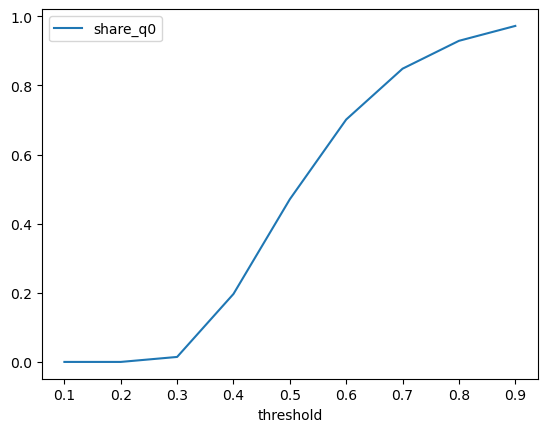

In [23]:
df_thr.plot(x='threshold', y='share_q0')

<Axes: xlabel='threshold'>

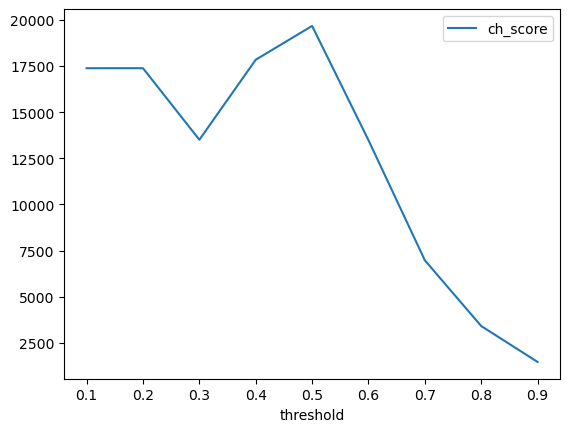

In [25]:
df_thr.plot(x='threshold', y='ch_score')

### Select threshold = 0.5

In [26]:
threshold = 0.5
def grouping(row):
        q_list = [row['q1'], row['q2'], row['q3'], row['q4']]
        if max(q_list) >= threshold:
            return f'q{q_list.index(max(q_list)) + 1}'
        else:
            return 'q0'
df_shares.loc[:, 'r_grp'] = df_shares.apply(lambda row: grouping(row), axis=1)
length_q0 = len(df_shares[df_shares['r_grp'] == 'q0'])
features = df_shares[['q1', 'q2', 'q3', 'q4']]
pred_labels = df_shares['r_grp']
silhouette_avg = silhouette_score(features, pred_labels)
ch_score = calinski_harabasz_score(features, pred_labels)
db_score = davies_bouldin_score(features, pred_labels)
print((threshold, length_q0/len(df_shares), silhouette_avg, ch_score, db_score))    # Peak ch_score

(0.5, 0.470848103274959, 0.3532221085288052, 19675.74779533446, 0.8858016413392423)


In [27]:
r_grp_dict = df_shares.set_index('h3_id')['r_grp'].to_dict()

## 3. Save mapping data

In [29]:
# Combine dictionaries into a single object (e.g., a tuple or dictionary)
data = (f_grp_dict, r_grp_dict)  # Using a tuple
# Alternatively: data = {'dict1': dict1, 'dict2': dict2}  # Using a dictionary

# Save to a pickle file
with open('dbs/combined_did_data/f_r_groups.pkl', 'wb') as f:
    pickle.dump(data, f)